In [1]:
# !pip install git+https://github.com/florencejt/fusilli.git
# !pip install nibabel

In [2]:
import os
import torch
import pandas as pd
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import tensor
import numpy as np
import nibabel as nib
import glob

from fusilli.data import prepare_fusion_data
from fusilli.train import train_and_save_models
from fusilli.fusionmodels.tabularimagefusion.concat_img_maps_tabular_maps import ConcatImageMapsTabularMaps
from fusilli.eval import RealsVsPreds, ConfusionMatrix

In [3]:
#print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))

In [4]:
## Data preprocessing
print('cwd (base):', os.getcwd(),'\n')

# open and load csv
base_dir = Path(r"C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0\ATLAS_2")  
meta_xlsx  = base_dir / "20220425_ATLAS_2.0_MetaData.xlsx"          
train_dir  = base_dir / "Training"  
test_dir   = base_dir / "Testing" 

meta_df = pd.read_excel(meta_xlsx)

cwd (base): C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0 



In [5]:
def norm_sub_id(x):
    s = str(x).strip()
    return s.replace("sub-","")

meta_df["ID"] = meta_df["Subject ID"].apply(norm_sub_id)

In [6]:
# T1w image paths
def find_t1_for_subject(sub_id: str) -> str | None:
    patterns = [
        str(train_dir / f"**/*{sub_id}*/*anat/*T1w*.nii*"),
        str(train_dir / f"**/*{sub_id}*/*T1w*.nii*"),
        str(train_dir / f"**/*{sub_id}*T1w*.nii*"),
    ]
    for pat in patterns:
        hits = glob.glob(pat, recursive=True)
        if hits:
            return hits[0]
    return None

meta_df["image_path"] = meta_df["ID"].apply(find_t1_for_subject)

before = len(meta_df)
meta_df = meta_df.dropna(subset=["image_path"]).reset_index(drop=True)
after = len(meta_df)
print(f"Fixed T1w paths for {after}/{before} subjects in Training")

Fixed T1w paths for 655/655 subjects in Training


In [7]:
# Add labels
def map_hemi(x):
    s = str(x).strip().lower()
    if s.startswith("l"): #Left
        return 0
    if s.startswith("r"): #Right
        return 1
    return 2 #Other

if "Primary Stroke Hemisphere" in meta_df.columns:
    meta_df["prediction_label"] = meta_df["Primary Stroke Hemisphere"].apply(map_hemi)
    
else:
    if "Lesion Volume" not in meta_df.columns:
        raise ValueError("Neither 'Primary Stroke Hemisphere' nor 'Lesion Volume' in MetaData.xlsx.")
    q = meta_df["Lesion Volume"].quantile([0.33, 0.66]).values
    
    def size_bin(v):
        if v <= q[0]: return 0
        if v <= q[1]: return 1
        return 2
        
    meta_df["prediction_label"] = meta_df["Lesion Volume"].apply(size_bin)
    print("Using 3-class lesion size bins from 'Lesion Volume'.")

In [8]:
# New csv for mapped data for later
mapped_csv = base_dir / "mapped_atlas_metadata.csv"
meta_df.to_csv(mapped_csv, index=False)
print(f"Saved mapped metadata in {mapped_csv}...\n")
print(meta_df[["ID","image_path","Primary Stroke Hemisphere" if "Primary Stroke Hemisphere" in meta_df.columns else "Lesion Volume"]].head())

Saved mapped metadata in C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0\ATLAS_2\mapped_atlas_metadata.csv...

         ID                                         image_path  \
0  r001s001  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
1  r001s002  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
2  r001s003  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
3  r001s004  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
4  r001s005  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   

  Primary Stroke Hemisphere  
0                     Right  
1                     Right  
2                     Right  
3                      Left  
4                      Left  


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

def middle_axial_slice_2uint8(nifti_path: Path) -> Image.Image:
    ni = nib.load(str(nifti_path))
    data = ni.get_fdata()
    z = data.shape[2] // 2
    slice2d = data[:, :, z]
    lo, hi = np.percentile(slice2d[np.isfinite(slice2d)], [1, 99])
    slice2d = np.clip((slice2d - lo) / (hi - lo + 1e-8), 0, 1)
    slice2d = (slice2d * 255.0).astype(np.uint8)
    return Image.fromarray(slice2d)  # single-channel

df = pd.read_csv(mapped_csv)
images, valid_idx = [], []
for i, row in tqdm(df.iterrows(), total=len(df)):
    p = Path(row["image_path"])
    if not p.exists(): continue
    pil_img = middle_axial_slice_2uint8(p)
    images.append(transform(pil_img))   # [1, 224, 224]
    valid_idx.append(i)

image_tensor = torch.stack(images)      # [N, 1, 224, 224]
torch.save(image_tensor, base_dir / "images.pt")
df = df.loc[valid_idx].reset_index(drop=True)
df.to_csv(mapped_csv, index=False)
print("Saved image tensor:", base_dir / "images.pt", "shape:", image_tensor.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 655/655 [02:16<00:00,  4.81it/s]


Saved image tensor: C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0\ATLAS_2\images.pt shape: torch.Size([655, 1, 224, 224])


In [10]:
df_numeric = pd.read_csv(mapped_csv)
df_numeric["prediction_label"] = pd.to_numeric(df_numeric["prediction_label"], errors="coerce").astype("Int64")
non_feature_cols = {"ID", "prediction_label"}

def to_numeric_series(s: pd.Series) -> pd.Series:
    if s.dtype.kind in "biufc":
        return s
    str_s = s.astype(str).str.strip()
    first_number = str_s.str.extract(r"([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)", expand=False)
    out = pd.to_numeric(first_number, errors="coerce")
    return out

clean = {}
for c in df_numeric.columns:
    if c in non_feature_cols:
        clean[c] = df_numeric[c]
    else:
        clean[c] = to_numeric_series(df_numeric[c])

clean = pd.DataFrame(clean)

feature_cols = [c for c in clean.columns if c not in non_feature_cols]
min_non_na = max(10, int(0.6 * len(clean))) 
kept = []
dropped = []
for c in feature_cols:
    if clean[c].notna().sum() >= min_non_na:
        kept.append(c)
    else:
        dropped.append(c)
clean = clean[["ID", "prediction_label"] + kept].dropna().reset_index(drop=True)

clean[kept] = clean[kept].astype("float32")
clean["prediction_label"] = clean["prediction_label"].astype("int64")

tabular_csv = base_dir / "mapped_atlas_numeric.csv"
clean.to_csv(tabular_csv, index=False)

print(f"[Tabular cleanup] kept {len(kept)} numeric feature columns; dropped {len(dropped)}: {dropped}")
print(f"[Tabular cleanup] final shape: {clean.shape}")



data_paths = {
    "tabular1": str(tabular_csv),
    "tabular2": "",
    "image": str(base_dir / "images.pt"),
}

[Tabular cleanup] kept 13 numeric feature columns; dropped 11: ['Organism', 'Organism Part', 'Developmental Stage', 'Primary Stroke Hemisphere', 'Primary Stroke Location', 'Secondary Stroke Hemisphere', 'Secondary Stroke Location', 'Scanner Brand', 'ATLAS 1.2 Subject ID', 'INDI Subject ID', 'Chronicity']
[Tabular cleanup] final shape: (544, 15)


In [11]:
output_paths = {
    "checkpoints": "outputs/checkpoints",
    "losses": "outputs/losses",
    "figures": "outputs/figures",
}
for p in output_paths.values():
    os.makedirs(p, exist_ok=True)

In [12]:
data_module = prepare_fusion_data(
    prediction_task="multiclass",
    fusion_model=ConcatImageMapsTabularMaps,
    data_paths=data_paths,
    output_paths=output_paths,
    batch_size=8,
    test_size=0.2,
    multiclass_dimensions=3,
    image_downsample_size=(224, 224),  # default for CNNs
    num_workers=4
)

In [13]:
# df_counts = df_numeric['prediction_label'].value_counts()
# weights = df_numeric['prediction_label'].apply(lambda x: 1/class_counts[x]).values
# pos_weight = tensor(weight_for_0)

In [14]:
import torch
import pandas as pd

counts = df_numeric['prediction_label'].value_counts().sort_index()

inv_freq = (counts.sum() / (len(counts) * counts)).values
class_weights = torch.tensor(inv_freq, dtype=torch.float)
print("class_weights [w0,w1,w2]:", class_weights.tolist())

class_weights [w0,w1,w2]: [0.7426303625106812, 0.7554786801338196, 3.032407522201538]


In [16]:
trained_model = train_and_save_models(
    data_module=data_module,
    fusion_model=ConcatImageMapsTabularMaps,
    training_modifications={
        "accelerator": "cpu",
        "devices": 1,       # number of GPUs
         "loss_params": {
        #     "pos_weight": pos_weight
        "weight": class_weights },
        # "precision": 16,    # mixed precision
    },
    max_epochs=100,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                       | Params | Mode 
-------------------------------------------------------------
0 | model | ConcatImageMapsTabularMaps | 2.8 M  | train
-------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.234    Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode
C:\Users\bnish\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
C:\Users\bnish\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                      | 0/? [00:00<…

C:\Users\bnish\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
C:\Users\bnish\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.6611514091491699     │
│       Accuracy_val        │    0.5277777910232544     │
│         val_loss          │    0.9349795579910278     │
└───────────────────────────┴───────────────────────────┘

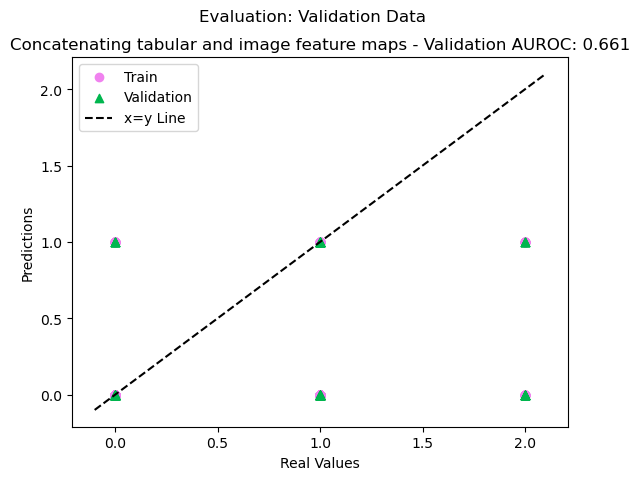

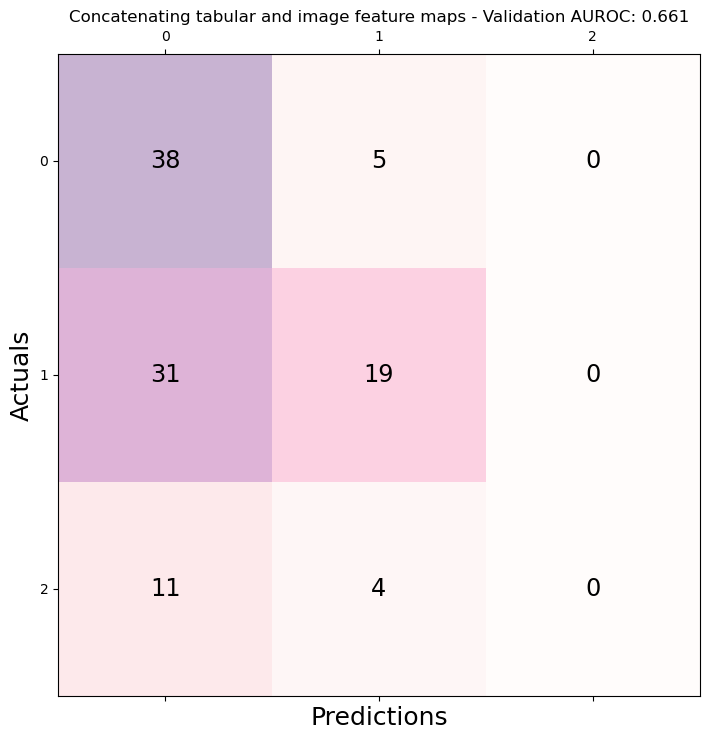

In [17]:
RealsVsPreds.from_final_val_data(trained_model)
ConfusionMatrix.from_final_val_data(trained_model)
plt.show()